<H1> Prediction of Starbucks Customers Loyalty Status

<H2> Data Source

https://www.kaggle.com/datasets/mahirahmzh/starbucks-customer-retention-malaysia-survey

<H2> Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

<h2> Load Data

In [2]:
df = pd.read_csv("../data/raw_data.csv")

<h2> Understanding Data

In [3]:
df

,Timestamp,1. Your Gender,2. Your Age,3. Are you currently....?,4. What is your annual income?,5. How often do you visit Starbucks?,6. How do you usually enjoy Starbucks?,7. How much time do you normally spend during your visit?,8. The nearest Starbucks's outlet to you is...?,9. Do you have Starbucks membership card?,...,"11. On average, how much would you spend at Starbucks per visit?","12. How would you rate the quality of Starbucks compared to other brands (Coffee Bean, Old Town White Coffee..) to be:",13. How would you rate the price range at Starbucks?,14. How important are sales and promotions in your purchase decision?,"15. How would you rate the ambiance at Starbucks? (lighting, music, etc...)",16. You rate the WiFi quality at Starbucks as..,"17. How would you rate the service at Starbucks? (Promptness, friendliness, etc..)",18. How likely you will choose Starbucks for doing business meetings or hangout with friends?,19. How do you come to hear of promotions at Starbucks? Check all that apply.,20. Will you continue buying at Starbucks?
0,2019/10/01 12:38:43 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,within 1km,Yes,...,Less than RM20,4,3,5,5,4,4,3,Starbucks Website/Apps;Social Media;Emails;Dea...,Yes
1,2019/10/01 12:38:54 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,1km - 3km,Yes,...,Less than RM20,4,3,4,4,4,5,2,Social Media;In Store displays,Yes
2,2019/10/01 12:38:56 PM GMT+8,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 30 minutes to 1 hour,more than 3km,Yes,...,Less than RM20,4,3,4,4,4,4,3,In Store displays;Billboards,Yes
3,2019/10/01 12:39:08 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,more than 3km,No,...,Less than RM20,2,1,4,3,3,3,3,Through friends and word of mouth,No
4,2019/10/01 12:39:20 PM GMT+8,Male,From 20 to 29,Student,"Less than RM25,000",Monthly,Take away,Between 30 minutes to 1 hour,1km - 3km,No,...,Around RM20 - RM40,3,3,4,2,2,3,3,Starbucks Website/Apps;Social Media,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2019/10/04 12:24:26 AM GMT+8,Male,40 and above,Self-employed,"RM25,000 - RM50,000",Monthly,Dine in,Between 1 hour to 2 hours,1km - 3km,Yes,...,Around RM20 - RM40,3,3,5,3,2,4,4,Starbucks Website/Apps;Social Media,Yes
118,2019/10/04 9:30:09 AM GMT+8,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 1 hour to 2 hours,1km - 3km,Yes,...,More than RM40,5,5,5,5,5,5,5,Starbucks Website/Apps;Social Media;Emails;Dea...,Yes
119,2019/10/04 1:46:07 PM GMT+8,Male,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,1km - 3km,No,...,Less than RM20,3,2,4,3,3,3,4,Social Media;Through friends and word of mouth...,No
120,2019/10/05 11:01:14 AM GMT+8,Female,From 20 to 29,Employed,"Less than RM25,000",Rarely,Take away,Below 30 minutes,within 1km,No,...,Less than RM20,4,4,4,4,4,4,4,Social Media;Through friends and word of mouth...,Yes


<h2> Renaming Features

In [4]:
new_feature_names = ['timestamp', 'gender', 'age', 'occupation', 'annualIncome', 'visitingFrequency', 'visitingMethod', 'timeSpent', 'distanceToStarbucks ', 'hasMembership ', 'favouriteProduct', 'averageExpensePerVisit', 'overallRating', 'priceRating', 'needPromotion', 'ambienceRating', 'wifiRating', 'serviceRating', 'forMeetingHangout','promotionMarketingMedia','loyaltyStatus']
df.columns = new_feature_names

<h2> Handling Missing Values

In [5]:
df.isna().sum()

timestamp                  0
gender                     0
age                        0
occupation                 0
annualIncome               0
visitingFrequency          0
visitingMethod             1
timeSpent                  0
distanceToStarbucks        0
hasMembership              0
favouriteProduct           0
averageExpensePerVisit     0
overallRating              0
priceRating                0
needPromotion              0
ambienceRating             0
wifiRating                 0
serviceRating              0
forMeetingHangout          0
promotionMarketingMedia    1
loyaltyStatus              0
dtype: int64

In [6]:
df['visitingMethod'][df['promotionMarketingMedia'].isna()]

81    NaN
Name: visitingMethod, dtype: object

-> The row with missing "visitingMethod" value has missing value of "promotionMarketing" too. Therefore, this is the only row with missing values.

In [7]:
df.dropna(inplace=True)

<h2> Handling Duplication

In [8]:
df.duplicated().sum()

0

<h2> Dropping Timestamp

In [9]:
df.drop('timestamp', axis=1, inplace=True)

In [10]:
df.columns

Index(['gender', 'age', 'occupation', 'annualIncome', 'visitingFrequency',
       'visitingMethod', 'timeSpent', 'distanceToStarbucks ', 'hasMembership ',
       'favouriteProduct', 'averageExpensePerVisit', 'overallRating',
       'priceRating', 'needPromotion', 'ambienceRating', 'wifiRating',
       'serviceRating', 'forMeetingHangout', 'promotionMarketingMedia',
       'loyaltyStatus'],
      dtype='object')

<h2> Refining VisitingMethod

In [11]:
df['visitingMethod'].replace(['never', 'Never buy', 'I dont like coffee', 'Never', 'Never ',], 'Never buy', inplace = True)

<H2> Univariate Analysis

In [12]:
# These steps are necessary because the following two features may include mutliple values within one entry
temp_favouriteProduct = df.copy()
temp_favouriteProduct = temp_favouriteProduct['favouriteProduct'].str.split(';', expand=True).stack().str.strip().replace({'never':'Nothing', 'Never':'Nothing', 'Juices':'Cold drinks', 'Cake': 'Pastries', 'Jaws chip': 'Chips'}).reset_index(level=1, drop=True).rename('favouriteProduct')
exploded_df_favouriteProduct = df.drop(columns=['favouriteProduct']).join(temp_favouriteProduct)

temp_promotionMarketingMedia = df.copy()
temp_promotionMarketingMedia = temp_promotionMarketingMedia['promotionMarketingMedia'].str.split(';', expand=True).stack().reset_index(level=1, drop=True).rename('promotionMarketingMedia')
exploded_df_promotionMarketingMedia = df.drop(columns=['promotionMarketingMedia']).join(temp_promotionMarketingMedia)

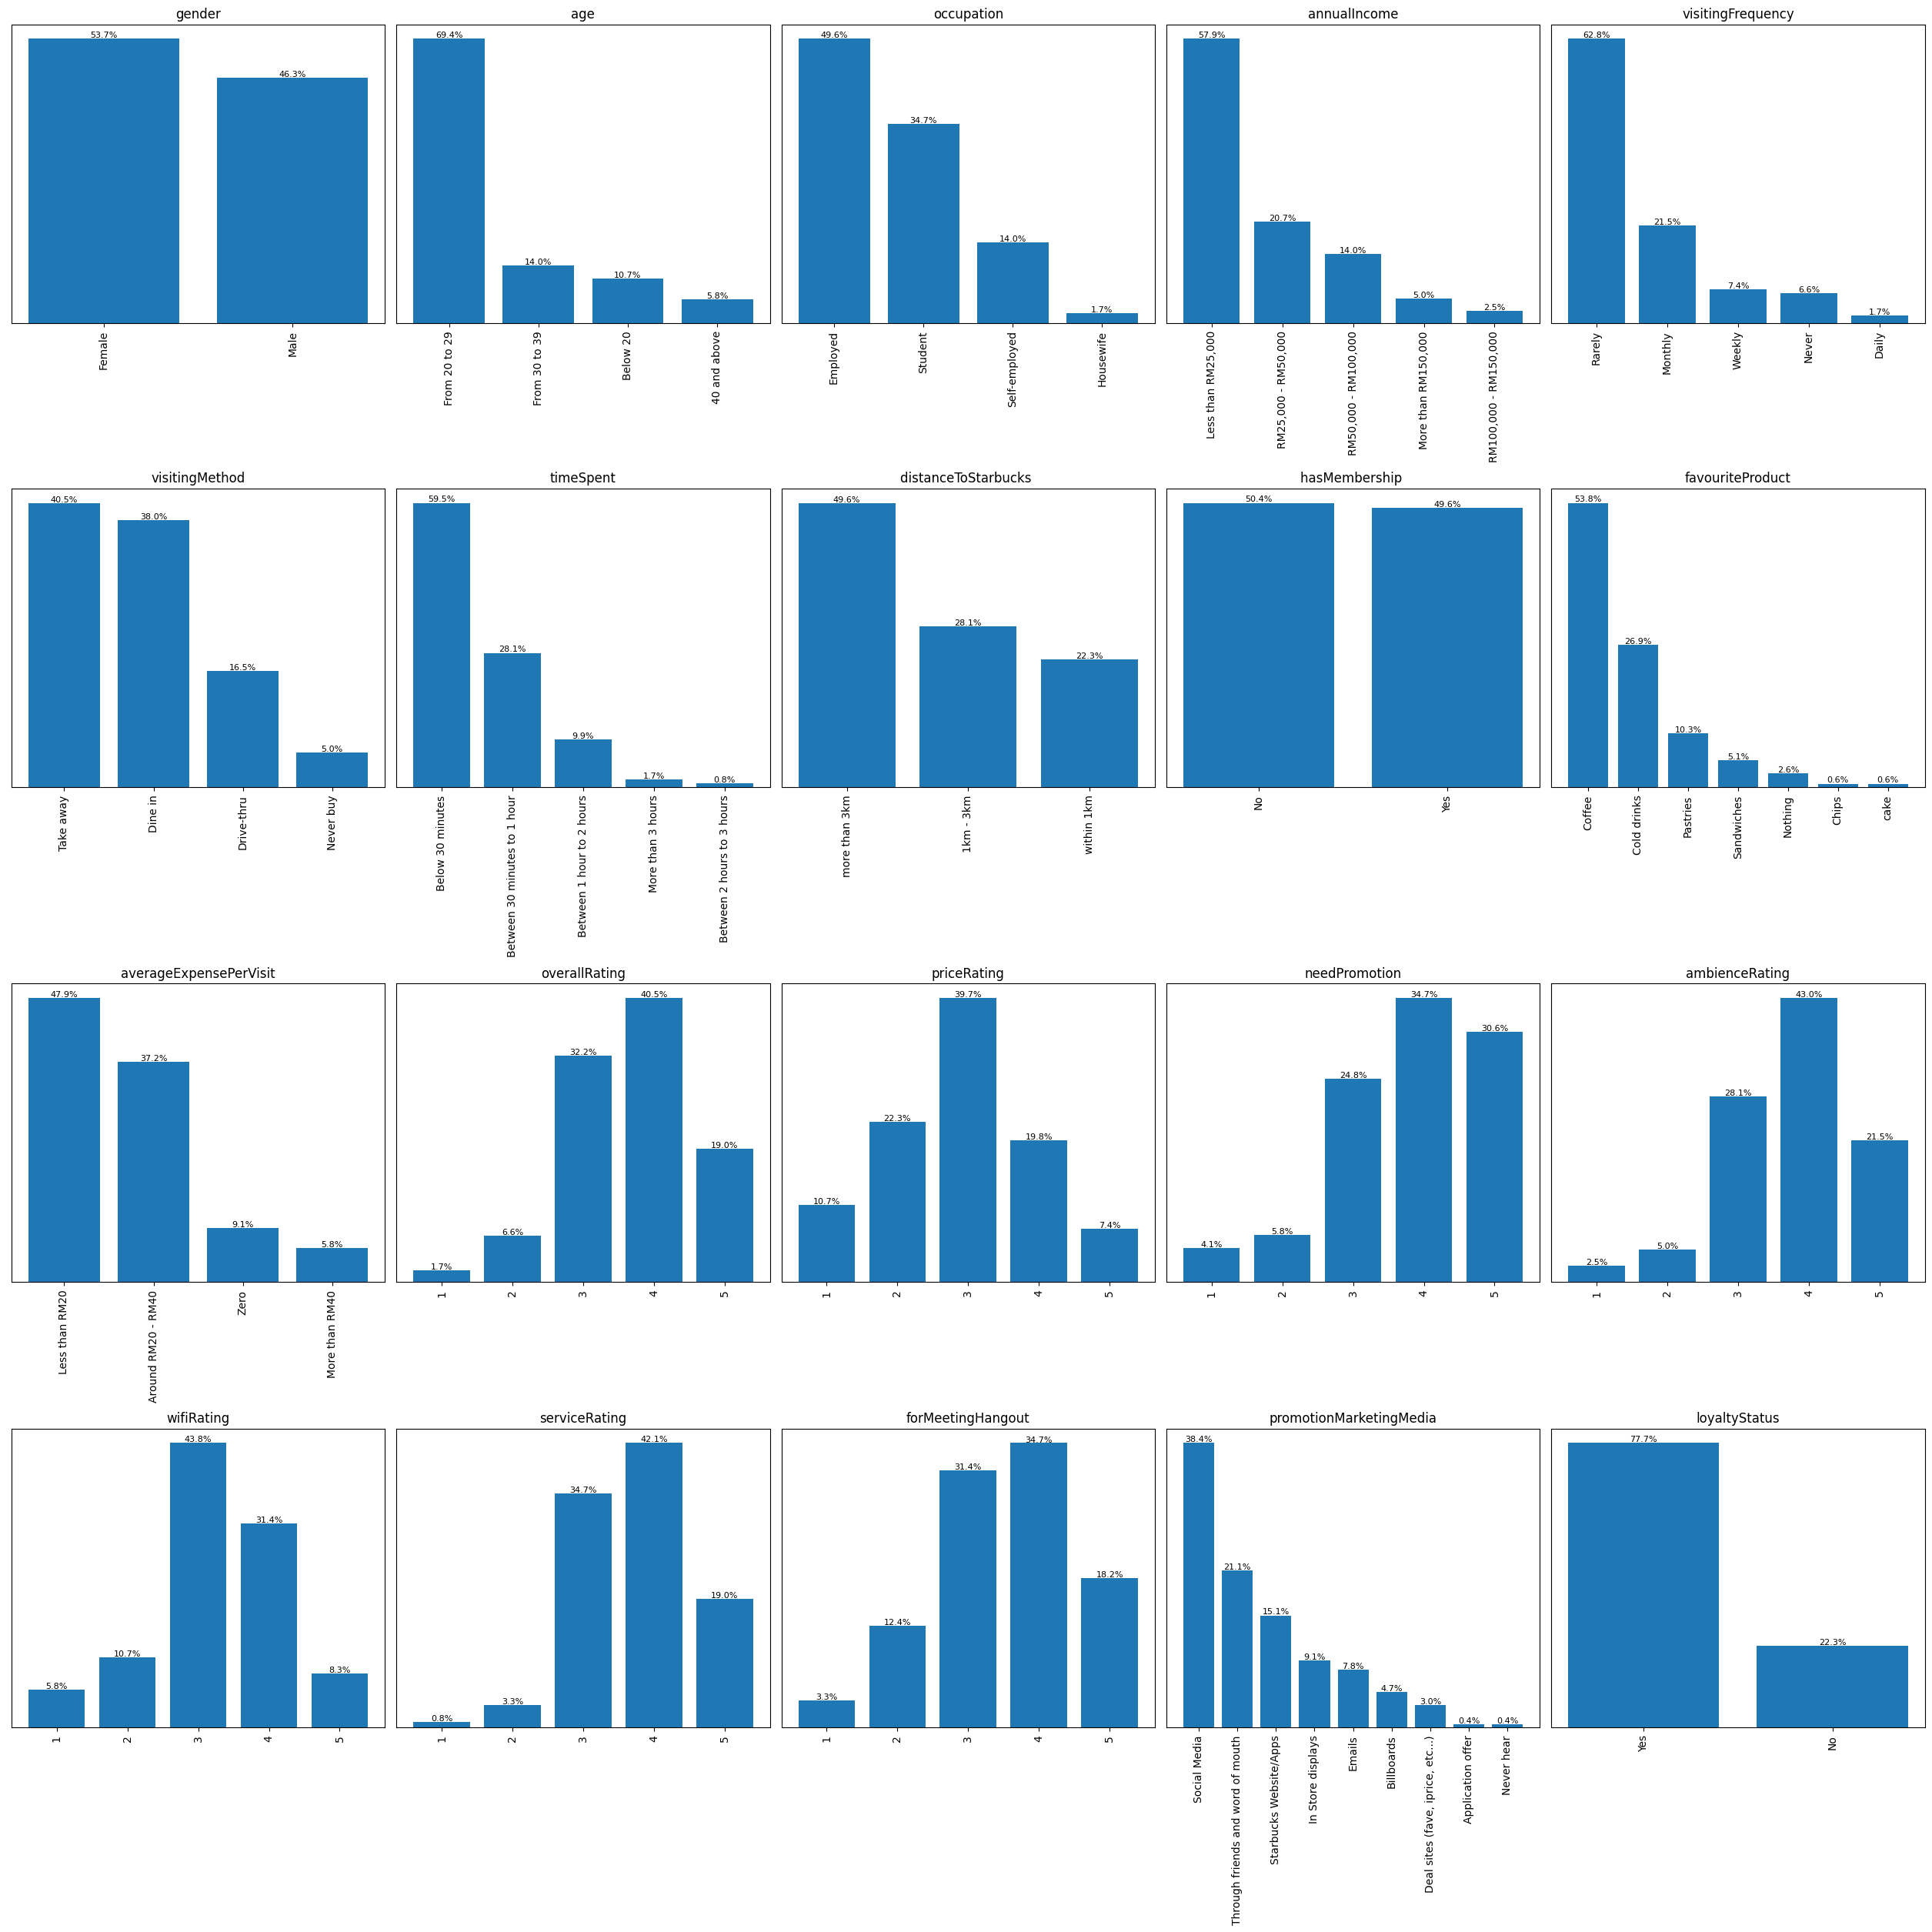

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 25), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(df.columns):
    if col == 'favouriteProduct':
        value_counts = exploded_df_favouriteProduct['favouriteProduct'].value_counts()
    elif col == 'promotionMarketingMedia':
        value_counts = exploded_df_promotionMarketingMedia['promotionMarketingMedia'].value_counts()
    else:
        value_counts = df[col].value_counts()
    
    percentages = (value_counts / value_counts.sum()) * 100
    bars = axes[i].bar(value_counts.index, value_counts.values)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_yticks([])
    axes[i].tick_params(axis='x', rotation = 90)
    
    for bar, percent in zip(bars, percentages):
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.05,
            f'{percent:.1f}%',
            ha='center', va='bottom', fontsize=8
        )

plt.show()

<h2> One-hot Encoding (Independent Variables) + Label Encoding (Target Variable)

In [14]:
X = df.drop('loyaltyStatus', axis=1)
y = df['loyaltyStatus']

categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(exclude=['object']).columns

encoder_simple_X = OneHotEncoder(sparse_output=False)
encoded_simple_X = pd.DataFrame(encoder_simple_X.fit_transform(X[categorical_columns].drop(columns=['favouriteProduct', 'promotionMarketingMedia'])), columns=encoder_simple_X.get_feature_names_out(categorical_columns.drop(['favouriteProduct', 'promotionMarketingMedia'])), index=X.index)

encoder_favouriteProduct = OneHotEncoder(sparse_output=False)
encoded_favouriteProduct = pd.DataFrame(encoder_favouriteProduct.fit_transform(exploded_df_favouriteProduct[['favouriteProduct']]), columns=encoder_favouriteProduct.get_feature_names_out(['favouriteProduct']), index=exploded_df_favouriteProduct.index)
encoded_favouriteProduct = encoded_favouriteProduct.groupby(encoded_favouriteProduct.index).sum()

encoder_promotionMarketingMedia = OneHotEncoder(sparse_output=False)
encoded_promotionMarketingMedia = pd.DataFrame(encoder_promotionMarketingMedia.fit_transform(exploded_df_promotionMarketingMedia[['promotionMarketingMedia']]), columns=encoder_promotionMarketingMedia.get_feature_names_out(['promotionMarketingMedia']), index=exploded_df_promotionMarketingMedia.index)
encoded_promotionMarketingMedia = encoded_promotionMarketingMedia.groupby(encoded_promotionMarketingMedia.index).sum()

encoded_X = pd.concat([X[numerical_columns].reset_index(drop=True), encoded_simple_X.reset_index(drop=True), encoded_favouriteProduct.reset_index(drop=True), encoded_promotionMarketingMedia.reset_index(drop=True)],axis=1)
encoded_X.loc[[38, 52, 117], 'favouriteProduct_Cold drinks'] = 1.0

encoded_y = LabelEncoder().fit_transform(y)

<h2> Train-test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(encoded_X, encoded_y, test_size=0.2, random_state=42)

<H2> SMOTE

In [16]:
X_train_resampled, y_train_resampled = SMOTE(sampling_strategy=0.9, random_state=42).fit_resample(X_train, y_train)

<h2> Classification

In [17]:
models = {
    "LR": LogisticRegression(random_state=42),
    "kNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(random_state=42)
}
results = []
setting_counter = 1

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    results.append({
        "Experimental Setting": f"M{setting_counter}",
        "Training Accuracy": accuracy_score(y_train, y_train_pred),
        "Training Precision": precision_score(y_train, y_train_pred),
        "Training Recall": recall_score(y_train, y_train_pred),
        "Training F1-score": f1_score(y_train, y_train_pred),
        "Testing Accuracy": accuracy_score(y_test, y_test_pred),
        "Testing Precision": precision_score(y_test, y_test_pred),
        "Testing Recall": recall_score(y_test, y_test_pred),
        "Testing F1-score": f1_score(y_test, y_test_pred)
    })
    setting_counter += 1
    
    model.fit(X_train_resampled, y_train_resampled)
    y_train_pred_resampled = model.predict(X_train_resampled)
    y_test_pred_resampled = model.predict(X_test)
    results.append({
        "Experimental Setting": f"M{setting_counter}",
        "Training Accuracy": accuracy_score(y_train_resampled, y_train_pred_resampled),
        "Training Precision": precision_score(y_train_resampled, y_train_pred_resampled),
        "Training Recall": recall_score(y_train_resampled, y_train_pred_resampled),
        "Training F1-score": f1_score(y_train_resampled, y_train_pred_resampled),
        "Testing Accuracy": accuracy_score(y_test, y_test_pred_resampled),
        "Testing Precision": precision_score(y_test, y_test_pred_resampled),
        "Testing Recall": recall_score(y_test, y_test_pred_resampled),
        "Testing F1-score": f1_score(y_test, y_test_pred_resampled)
    })
    setting_counter += 1

results_df = pd.DataFrame(results).set_index('Experimental Setting')
results_df

,Training Accuracy,Training Precision,Training Recall,Training F1-score,Testing Accuracy,Testing Precision,Testing Recall,Testing F1-score
Experimental Setting,,,,,,,,
M1,0.947917,0.937500,1.000000,0.967742,0.76,0.809524,0.894737,0.850000
M2,0.971831,0.973333,0.973333,0.973333,0.80,0.888889,0.842105,0.864865
M3,0.875000,0.879518,0.973333,0.924051,0.76,0.809524,0.894737,0.850000
M4,0.845070,0.981818,0.720000,0.830769,0.76,0.933333,0.736842,0.823529
M5,1.000000,1.000000,1.000000,1.000000,0.76,0.782609,0.947368,0.857143
M6,1.000000,1.000000,1.000000,1.000000,0.72,0.772727,0.894737,0.829268
